In [2]:
import os
import torchio as tio

from mbas.data.nifti import make_subject
from mbas.visualize.subject import plot_subject_with_label

%load_ext autoreload
%autoreload 2

import numpy as np
import pickle

from monai.metrics import (
    HausdorffDistanceMetric,
    DiceMetric
)
from monai.transforms import AsDiscrete, Compose

2024-06-16 09:26:18.625769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-16 09:26:18.648671: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 09:26:19.105477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
model_output_dir = "/home/bryan/expr/nnUNet_results/Dataset101_MBAS/nnUNetTrainer_250epochs__nnUNetResEncUNetMPlans__3d_cascade_fullres_from_only_atrium_orig01"
results_subdir = os.path.join(
    model_output_dir,
    "crossval_results_folds_0_1_2_3_4/postprocessed"
)

In [4]:
subject_id = "MBAS_005"
subject = make_subject(
    f"/home/bryan/data/MBAS/Training/{subject_id}",
    "train",
)
subject.add_image(
    tio.LabelMap(path=os.path.join(results_subdir, f"{subject_id}.nii.gz")),
    "predictions"
)

In [5]:
dice_metric = DiceMetric(
    include_background = False,
    reduction="mean",
    get_not_nans=False
)

hausdorff_metric = HausdorffDistanceMetric(
    include_background=False, percentile=95.0, directed=False
)

In [6]:
# Since labels are 1, 2, 3, we need 4 classes (0 to 3)
# to_onehot = AsDiscrete(to_onehot=4)
to_onehot = Compose([AsDiscrete(to_onehot=4), lambda x: x[None]])

predictions_onehot = to_onehot(subject.predictions.data)
label_onehot = to_onehot(subject.label.data)

dice_score = dice_metric(y_pred=predictions_onehot, y=label_onehot)
hausdorff_distance = hausdorff_metric(y_pred = predictions_onehot, y = label_onehot)

# hausdorff_distance = hausdorff_metric(y_pred = predictions_onehot, y = label_onehot)
# print("Hausdorff Distance:", hausdorff_distance.item())

In [7]:
dice_metric(y_pred=subject.predictions.data[None], y=subject.label.data[None])

tensor([[0.7077]])

In [16]:
hausdorff_distance.flatten().tolist()

[4.123105525970459, 4.582575798034668, 3.0]

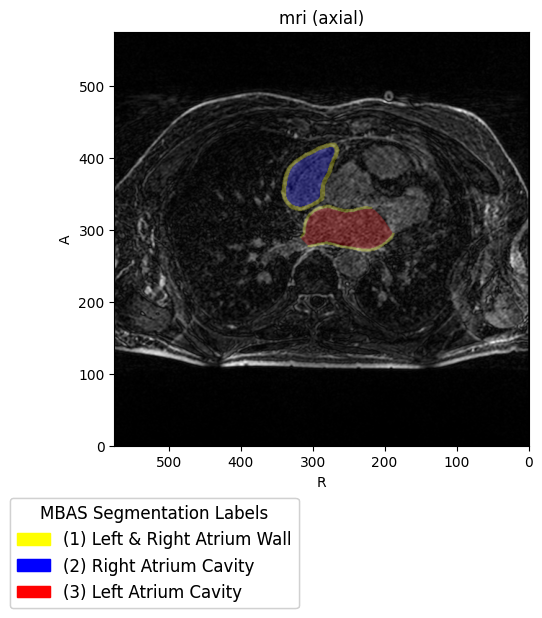

In [50]:
plot_subject_with_label(
    subject,
    show=True,
    add_metadata=False,
    add_segmentation_legend=True,
    single_axis="axial",
#     label_key="label",
    label_key="predictions",
    cmap="mbas",
#     indices = (300, 300, 8),
#     figsize=(10,3)
);